In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Circle, RegularPolygon
from matplotlib.path import Path
from matplotlib.projections.polar import PolarAxes
from matplotlib.projections import register_projection
from matplotlib.spines import Spine
from matplotlib.transforms import Affine2D
import seaborn as sns
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42

In [2]:
def radar_factory(num_vars, frame='circle'):
    """
    Create a radar chart with `num_vars` axes.

    This function creates a RadarAxes projection and registers it.

    Parameters
    ----------
    num_vars : int
        Number of variables for radar chart.
    frame : {'circle', 'polygon'}
        Shape of frame surrounding axes.

    """
    # calculate evenly-spaced axis angles
    theta = np.linspace(0, 2*np.pi, num_vars, endpoint=False)

    class RadarTransform(PolarAxes.PolarTransform):

        def transform_path_non_affine(self, path):
            # Paths with non-unit interpolation steps correspond to gridlines,
            # in which case we force interpolation (to defeat PolarTransform's
            # autoconversion to circular arcs).
            if path._interpolation_steps > 1:
                path = path.interpolated(num_vars)
            return Path(self.transform(path.vertices), path.codes)

    class RadarAxes(PolarAxes):

        name = 'radar'
        PolarTransform = RadarTransform

        def __init__(self, *args, **kwargs):
            super().__init__(*args, **kwargs)
            # rotate plot such that the first axis is at the top
            self.set_theta_zero_location('N')

        def fill(self, *args, closed=True, **kwargs):
            """Override fill so that line is closed by default"""
            return super().fill(closed=closed, *args, **kwargs)

        def plot(self, *args, **kwargs):
            """Override plot so that line is closed by default"""
            lines = super().plot(*args, **kwargs)
            for line in lines:
                self._close_line(line)

        def _close_line(self, line):
            x, y = line.get_data()
            # FIXME: markers at x[0], y[0] get doubled-up
            if x[0] != x[-1]:
                x = np.append(x, x[0])
                y = np.append(y, y[0])
                line.set_data(x, y)

        def set_varlabels(self, labels):
            self.set_thetagrids(np.degrees(theta), labels)

        def _gen_axes_patch(self):
            # The Axes patch must be centered at (0.5, 0.5) and of radius 0.5
            # in axes coordinates.
            if frame == 'circle':
                return Circle((0.5, 0.5), 0.5)
            elif frame == 'polygon':
                return RegularPolygon((0.5, 0.5), num_vars,
                                      radius=.5, edgecolor="k")
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

        def _gen_axes_spines(self):
            if frame == 'circle':
                return super()._gen_axes_spines()
            elif frame == 'polygon':
                # spine_type must be 'left'/'right'/'top'/'bottom'/'circle'.
                spine = Spine(axes=self,
                              spine_type='circle',
                              path=Path.unit_regular_polygon(num_vars))
                # unit_regular_polygon gives a polygon of radius 1 centered at
                # (0, 0) but we want a polygon of radius 0.5 centered at (0.5,
                # 0.5) in axes coordinates.
                spine.set_transform(Affine2D().scale(.5).translate(.5, .5)
                                    + self.transAxes)
                return {'polar': spine}
            else:
                raise ValueError("Unknown value for 'frame': %s" % frame)

    register_projection(RadarAxes)
    return theta

In [3]:
# Read in the model performances
rel_file = "../REL_output/all_metrics.tsv"
ner_file = "../NER_output/aggregated_eval.tsv"
rel_df = pd.read_csv(rel_file, delimiter="\t", index_col=0)
ner_df = pd.read_csv(ner_file, delimiter="\t", index_col=0)

### NER

In [4]:
labels_flat = ner_df.index.tolist()

In [5]:
m = ner_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})

columns = ["eval_f1", "eval_precision", "eval_recall", "eval_loss", "test_f1", 
           "test_precision", "test_recall","test_loss"]
mf = m[m["metric"].isin(columns)]
mf["group"] = mf["metric"].str.split("_").str[0]
mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(
    "test_", "", regex=True).str.replace("train_", "", regex=True)
matrices = []
for group in mf.group.unique():
    matrix = mf[mf["group"] == group].loc[:, labels_flat].values.tolist()
    matrices.append((group, matrix))
data_mine = [labels_flat, matrices[0], matrices[1]]
N = len(labels_flat)
theta = radar_factory(N, frame='polygon')
data = data_mine
spoke_labels = data.pop(0)

/tmp/ipykernel_61006/3058498775.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["group"] = mf["metric"].str.split("_").str[0]
/tmp/ipykernel_61006/3058498775.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(


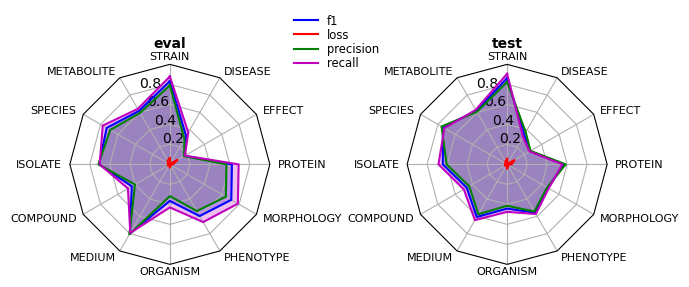

In [18]:
fig, axs = plt.subplots(figsize=(7.7, 2.5), ncols=2,
						subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=0.3, hspace=0.20, top=0.85, bottom=0.05)

legend_labels = []

for ax, (title, case_data) in zip(axs.flat, data):
	ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
	ax.set_ylim(0, 1)
	ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
				 horizontalalignment='center', verticalalignment='center')
	
	colors = ['b', 'r', 'g', 'm']  # Move colors inside the loop
	
	for d, color in zip(case_data, colors):
		ax.plot(theta, d, color=color)
		ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
	ax.set_varlabels(spoke_labels)
	legend_labels.extend(case_data)
	
	# Rotate the axis labels
	ax.set_thetagrids(np.degrees(theta), spoke_labels, fontsize=8)
	ax.tick_params(axis='x', pad=-5)  # Remove padding of x-tick labels
	for label, angle in zip(ax.get_xticklabels(), np.degrees(theta)):
		if angle in (0, 180):
			label.set_horizontalalignment('center')
		elif 0 < angle < 180:
			label.set_horizontalalignment('right')
		else:
			label.set_horizontalalignment('left')

# add legend relative to top-left plot
labs = tuple(mf.metric.drop_duplicates().to_list())
legend = axs[0].legend(labs, loc=(1.1, .95),
					   labelspacing=0.1, fontsize='small',frameon=False)

# fig.text(0.5, 1, 'NER performance',
# 		 horizontalalignment='center', color='black', weight='bold',
# 		 size='large')

plt.savefig("figures/performance/ner.pdf", bbox_inches='tight')
plt.savefig("figures/performance/ner.png", bbox_inches='tight', dpi=600)


#### REL

In [19]:
labels_flat = rel_df.index.tolist()

In [20]:
m = rel_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})

In [21]:
columns = ["eval_f1", "eval_precision", "eval_recall", "test_f1", 
           "test_precision", "test_recall"]

In [22]:
m = rel_df.transpose().reset_index()
m = m.rename(columns={"index": "metric"})
columns = ["eval_F1", "eval_precision", "eval_recall", "test_F1", 
           "test_precision", "test_recall"]
mf = m[m["metric"].isin(columns)]
mf["group"] = mf["metric"].str.split("_").str[0]
mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(
    "test_", "", regex=True).str.replace("train_", "", regex=True)
matrices = []
for group in mf.group.unique():
    matrix = mf[mf["group"] == group].loc[:, labels_flat].values.tolist()
    matrices.append((group, matrix))
data_mine = [labels_flat, matrices[0], matrices[1]]
N = len(labels_flat)
theta = radar_factory(N, frame='polygon')

data = data_mine
spoke_labels = data.pop(0)
spoke_labels = [w.replace("STRAIN","S") for w in spoke_labels]



/tmp/ipykernel_61006/1603370077.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["group"] = mf["metric"].str.split("_").str[0]
/tmp/ipykernel_61006/1603370077.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  mf["metric"] = mf["metric"].str.replace("eval_", "", regex=True).str.replace(


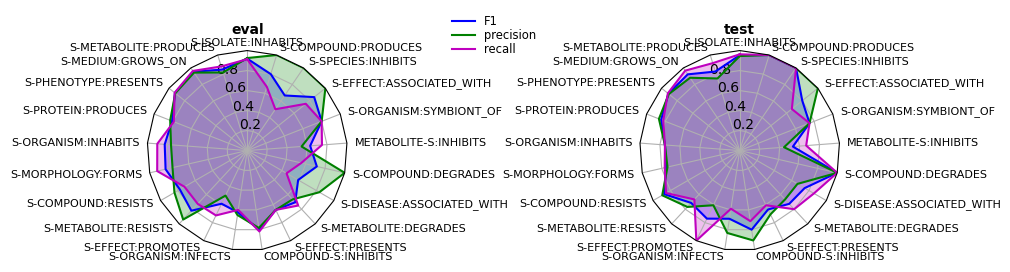

In [31]:
fig, axs = plt.subplots(figsize=(9.7, 2.5), ncols=2,
                        subplot_kw=dict(projection='radar'))
fig.subplots_adjust(wspace=.9, hspace=0.20, top=0.85, bottom=0.05)

colors = ['b', 'g', 'm']
legend_labels = []

for ax, (title, case_data) in zip(axs.flat, data):
    ax.set_rgrids([0.2, 0.4, 0.6, 0.8])
    ax.set_ylim(0, 1)
    ax.set_title(title, weight='bold', size='medium', position=(0.5, 1.1),
                 horizontalalignment='center', verticalalignment='center')
    for d, color in zip(case_data, colors):
        ax.plot(theta, d, color=color)
        ax.fill(theta, d, facecolor=color, alpha=0.25, label='_nolegend_')
    ax.set_varlabels(spoke_labels)
    legend_labels.extend(case_data)
    
    # Rotate the axis labels
    ax.set_thetagrids(np.degrees(theta), spoke_labels, fontsize=8)
    ax.tick_params(axis='x', pad=-5)  # Remove padding of x-tick labels
    for label, angle in zip(ax.get_xticklabels(), np.degrees(theta)):
        if angle in (0, 180):
            label.set_horizontalalignment('center')
        elif 0 < angle < 180:
            label.set_horizontalalignment('right')
        else:
            label.set_horizontalalignment('left')


# add legend relative to top-left plot
labs = tuple(mf.metric.drop_duplicates().to_list())
legend = axs[0].legend(labs, loc=(1.5, .95),
                       labelspacing=0.1, fontsize='small',frameon=False)

# fig.text(0.5, 1, 'REL performance',
#          horizontalalignment='center', color='black', weight='bold',
#          size='large')

plt.savefig("figures/performance/rel.pdf", bbox_inches='tight')
plt.savefig("figures/performance/rel.png", dpi=600, bbox_inches='tight')
